# **FRAUD DETECTION PROJECT**
### BY SHAURYA SINGRU & PAUL BABU
### Jupyter version

This notebook contains the sandbox code for collaborating and figuring out the application of a basic Fraud Detection machine learning model on a synthetic dataset sourced from Kaggle

Code includes:
- EDA
- Data preparation & pre-processing
- Model selection
- Model training
- Model evaluation

**IMPORTING DATA & LIBRARIES**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amanalisiddiqui/fraud-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 178M/178M [00:02<00:00, 76.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amanalisiddiqui/fraud-detection-dataset/versions/1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

**READING THE DATASET, PARSING DATES, AND SETTING DATATYPES**

In [ ]:
dataset_path =  path + "/AIML Dataset.csv"

# Defining datatypes of each column to optimise memory
dtypes = {
            # Numerical columns
            'step': 'int16',
            'amount': 'float32',
            'oldbalanceOrg': 'float32',
            'newbalanceOrig': 'float32',
            'oldbalanceDest': 'float32',
            'newbalanceDest': 'float32',
            'isFraud': 'category',
            'isFlaggedFraud': 'category',

            # Alphanumeric columns
            'type': 'category',
            'nameOrig': 'string',
            'nameDest': 'string',

        }


df = pd.read_csv(
                dataset_path,
                dtype = dtypes
                )

In [ ]:
round(df['isFraud'].value_counts(normalize=True)*100,2)

In [ ]:
# Viewing top 5 rows
df.head()

## About Dataset
The dataset contains the records of financial transactions for fraud detection. (6.3 Million Records)

Some of these records were flagged false by existing algorithms.

Further approaches could be used to feature engineer properties that could further strengthen the fraud detection algorithms as well as find out where the existing algorithm lacks.

#### **Columns**
|Column Name| Description|
|-----------|------------|
|**step** |Step denotes a portion of the time period
|**type** |Type of the transaction
|**amount** |Amount involved in transaction
|**nameOrig** |Name of the source account
|**oldbalanceOrg** |Old balance of source account
|**newbalanceOrig** |New balance of source account
|**nameDest** |Name of the target account
|**oldbalanceDest** |Old balance of target account
|**newbalanceDest** |New balance of target account
|**isFraud** |1 means is Fraud 0 means its not
|**isFlaggedFraud** |Was the system able to detect if the transaction is fraud or not based on existing techniques



Under Type the following are the details:
- **CASH-IN**: is the process of increasing the balance ofaccount by paying in cash to a merchant.

- **CASH-OUT**: is the opposite process of CASH-IN, it means to withdraw cash from a merchant which decreasesthe balance of the account.

- **DEBIT**: is similar process than CASH-OUT and involves sending the money from the mobile money service to a bank account.

- **PAYMENT**: is the process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver.

- **TRANSFER**: is the process of sending money to another user of the service through the mobile money platform``

## **EDA**

In [ ]:
# Defining a function that gives value counts and proportions of a given series as well as the visualisation of the value counts

def value_counts_percent(pd_series: pd.Series, ascending: bool = False, visualise: bool = True, re: bool = False) -> pd.DataFrame:

  value_counts = pd_series.value_counts(ascending = ascending)
  value_percent = (pd_series.value_counts(ascending = ascending, normalize = True) * 100).round(3)
  series_name = pd_series.name
  series_index = value_counts.index

  results = pd.concat(
                      [
                          pd_series.value_counts(ascending = ascending),
                          (pd_series.value_counts(ascending = ascending, normalize = True) * 100).round(3)
                      ],
                      axis = 1
                      ).rename(
                                {'proportion': 'percentage'},
                                axis = 1
                              )

  display(results)

  if visualise:
    fig, ax = plt.subplots()
    ax.bar(series_index, value_counts)
    ax.set_ylabel(f'Count of {series_name}')
    ax.set_xlabel(series_name)
    plt.show()

  if re:
    return results

In [ ]:
# Finding number of rows marked as Fraud and Not Fraud

value_counts_percent(df['isFraud'])

In [ ]:
# Finding number of rows flaged as Fraud or Not Fraud

value_counts_percent(df['isFlaggedFraud'])

In [ ]:
# Showing transactions by type

value_counts_percent(df['type'])

In [ ]:
# Transaction types for fraud cases

fraud_df = df[df['isFraud'] == '1']

value_counts_percent(fraud_df['type'])

In [ ]:
# Finding fraud rates for each type of transaction

fraud_rates_by_types = ((fraud_df['type'].value_counts().sort_index() / df['type'].value_counts().sort_index()) * 100).rename('fraud_rate').sort_values(ascending = False)

display(fraud_rates_by_types)

fraud_rates_by_types.plot(kind = 'bar')
plt.show()

As per the above graph, on average, the highest number of fraud rate is observed in **TRANSFER** type transactions

### Finding the distribution of the 'amount' column

In [ ]:
df['hour_of_day'] = df['step'] % 24
df.astype({'isFraud':'int'}).groupby('hour_of_day')['isFraud'].mean().plot(kind='bar')

In [ ]:
sns.histplot(np.log1p(df["amount"]),bins=75, kde=True, color="green") #Use kde = True for a density function
#np.log1p is used to return the precise value for small numbers

plt.title("Transaction Amount Distribution (log scale)")
plt.xlabel("Log(Amount + 1)")
plt.show()

### Boxplot of amount vs isFraud

Finding the boxplot on the dataset filtered for "small" amounts, i.e, amounts under 100k units of currency

In [ ]:
sns.boxplot(data=df[df["amount"] < 1e5], x = "isFraud", y = "amount")
plt.title("Amount vs isFraud(Filtered under 100k)")
plt.show()

We can see from above plot that Fraud transactions have both a higher median transaction value as well as interquartile range. This means fraud transactions generally deal in 40k units of amount, which is higher than the median transaction value of a non-fraud transaction

### Plotting the relationship between fraud and time (the 'step' column)

In [ ]:
df['step'].value_counts().sort_index()

In [ ]:
fraud_per_step = fraud_df.groupby('step').size().rename('total_fraud_transactions')
fraud_per_step.plot(figsize=(12,5))
plt.title("Fraud Count per Step")
plt.xlabel("Step (Hour)")
plt.ylabel("Fraud Count")
plt.show()

The above plot shows the number of fraud transactions per hour. It seems as if the number of fraudulent transactions is time-invariant

In [ ]:
from matplotlib.figure import figaspect
trans_per_step = df.groupby('step').size().sort_index().rename('total_transactions')
fraud_rate_per_step = (fraud_per_step / trans_per_step * 100).rename('fraud_rate').fillna(0)

fig, ax = plt.subplots()
ax.plot(fraud_rate_per_step)
fig.set_size_inches(25,5)
plt.show()

However, when we factor in the



In [ ]:
df['day_of_month'] = df['step'] // 24 + 1
df.head()

In [ ]:
fraud_by_day = df.astype({'isFraud':'int8'}).groupby('day_of_month')['isFraud'].sum().rename('total_fraud_transactions')
trans_by_day = df.groupby('day_of_month').size().rename('total_transactions')
fraud_rate_by_day = (fraud_by_day / trans_by_day * 100).fillna(0).rename('fraud_rate')

fig, ax = plt.subplots(3,1)

for i, series in enumerate([fraud_by_day, trans_by_day, fraud_rate_by_day]):
  ax[i].plot(series)
  ax[i].set_title(series.name)
  ax[i].set_xlim(1,31)
  if i < 2:
    ax[i].xaxis.set_visible(False)
    ax[i].set_ylabel('Count')
  else:
    ax[i].set_xlabel('Day of month')
    ax[i].set_ylabel('Percentage')
fig.set_size_inches(10,10)
# plt.subplots_adjust(hspace = 0.5)
plt.show()

Based on the above graphs, we can see that the rate of fraud is almost level around 2-3% from Day 1 till Day 30, and then spikes up to 100% on Day 31. This seems to be a quirk with the synthetic nature of the dataset, and does not make any real life sense, hence we can drop the *step* and *day_of_month* variables

In [ ]:
#creating a copy of dataset to drop time variable for now
df_cleaned = df.drop(columns = 'step')

In [ ]:
df_cleaned

### Cross-correlation plot

In [ ]:
corr = df[["amount","oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]].corr()

In [ ]:
corr

In [ ]:
sns.heatmap(corr,  xticklabels=corr.columns, yticklabels=corr.columns, annot = True, cmap = "coolwarm_r", fmt=".2f")
plt.title("Correlation Martrix")
plt.show()

In [ ]:
from matplotlib import pyplot as plt
df_cleaned.plot(kind='scatter', x='amount', y='newbalanceDest', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def explore_dataframe(df, bins):
    """
    Plots histograms for all numeric columns
    and prints descriptive statistics.

    Parameters:
        df (DataFrame): Input pandas dataframe
        bins (int): Number of histogram bins
    """

    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns

    print("=====================================")
    print("📌 DESCRIPTIVE STATISTICS")
    print("=====================================")
    display(df[numeric_cols].describe().T)

    print("\n=====================================")
    print("📊 HISTOGRAMS OF NUMERIC COLUMNS")
    print("=====================================")

    # Grid setup
    num_plots = len(numeric_cols)
    cols = 3  # Number of plots per row
    rows = (num_plots // cols) + 1

    plt.figure(figsize=(15, 5 * rows))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        plt.hist(df[col].dropna(), bins=bins)
        plt.title(col, fontsize=12)
        plt.xlabel(col)
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [ ]:
explore_dataframe(df, 10)

In [ ]:
df['timestamp'] = pd.to_datetime('2020-01-01') + pd.to_timedelta(df['step'], unit='h')
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday


In [ ]:
df.head()

In [ ]:
transactions_per_step = df.groupby('step').size()

transactions_per_step.plot(figsize=(12,5))
plt.title("Number of Transactions per Step")
plt.xlabel("Step (Hour)")
plt.ylabel("Count")
plt.show()


In [ ]:
transactions_per_step.sort_values(ascending=True)

In [ ]:
transactions_per_step_type = df.groupby(['step', 'type']).size().reset_index(name='count')

In [ ]:
fraud_per_step = df[df['isFraud'] == "1"].groupby('step').size()
fraud_per_step.plot(figsize=(12,5))
plt.title("Fraud Count per Step")
plt.xlabel("Step (Hour)")
plt.ylabel("Fraud Count")
plt.show()


In [ ]:
df['isFraud'].astype("int").sum()

# FEATURE SELECTION AND MACHINE LEARNING

## Step 0: Feature selection
1. Drop any columns that are not needed
1. Create lists of features that are numeric and categorical
1. Set appropriate datatytpes for features
1. Create any new features
1. Split dataset into target variable vector *y* and feature matrix *X*

1. Drop any columns that are not needed

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day_of_month,timestamp,day,hour,weekday
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0,1,1,2020-01-01 01:00:00,1,1,2
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0,1,1,2020-01-01 01:00:00,1,1,2
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0,1,1,2020-01-01 01:00:00,1,1,2
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0,1,1,2020-01-01 01:00:00,1,1,2
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0,1,1,2020-01-01 01:00:00,1,1,2


In [ ]:
columns_to_remove = [
                      "step", #As discussed earlier, the transactions don't seem to have a realistic relationship with time, owing to the data being synthetic
                      "timestamp",#Same reason as above
                      "weekday", #Same reason as above
                      "day_of_month", #Same reason as above
                      "day", #Same reason as above
                      "hour", #Same reason as above
                      "nameOrig", #In this dataset, most of the transactions are done by unique account. Therefore, it does not reveal any further information about the transaction being fraud
                      "nameDest", #Same reason as above
                      "isFlaggedFraud" #This is not required for modelling purposes
                      ]

In [ ]:
df_clean = df.drop(columns=columns_to_remove)

In [ ]:
df_clean.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour_of_day
0,PAYMENT,9839.639648,170136.0,160296.359375,0.0,0.0,0,1
1,PAYMENT,1864.280029,21249.0,19384.720703,0.0,0.0,0,1
2,TRANSFER,181.000000,181.0,0.000000,0.0,0.0,1,1
3,CASH_OUT,181.000000,181.0,0.000000,21182.0,0.0,1,1
4,PAYMENT,11668.139648,41554.0,29885.859375,0.0,0.0,0,1


2. Create lists of features that are numeric and categorical


In [ ]:
numerical = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
categorical = ["type", "hour_of_day"]

3. Set appropriate datatytpes for features

In [ ]:
df_clean.dtypes

,0
type,category
amount,float32
oldbalanceOrg,float32
newbalanceOrig,float32
oldbalanceDest,float32
newbalanceDest,float32
isFraud,category
hour_of_day,int16


Data types were set during the import of the dataset

4. Create any new features


No additional features added to the model

5. Split dataset into target variable vector *y* and feature matrix *X*

In [ ]:
y, X = df_clean["isFraud"], df_clean.drop(columns="isFraud")

display(y,X)

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
6362615,1
6362616,1
6362617,1
6362618,1


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour_of_day
0,PAYMENT,9.839640e+03,170136.000,160296.359375,0.000000e+00,0.000,1
1,PAYMENT,1.864280e+03,21249.000,19384.720703,0.000000e+00,0.000,1
2,TRANSFER,1.810000e+02,181.000,0.000000,0.000000e+00,0.000,1
3,CASH_OUT,1.810000e+02,181.000,0.000000,2.118200e+04,0.000,1
4,PAYMENT,1.166814e+04,41554.000,29885.859375,0.000000e+00,0.000,1
...,...,...,...,...,...,...,...
6362615,CASH_OUT,3.396821e+05,339682.125,0.000000,0.000000e+00,339682.125,23
6362616,TRANSFER,6.311410e+06,6311409.500,0.000000,0.000000e+00,0.000,23
6362617,CASH_OUT,6.311410e+06,6311409.500,0.000000,6.848884e+04,6379898.000,23
6362618,TRANSFER,8.500025e+05,850002.500,0.000000,0.000000e+00,0.000,23


## Step 1: Split the datatset into training and testing groups

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

4453834
1908786
4453834
1908786


## Step 2: Preprocessing & data transformation: rescaling the dataset, transforming the columns, and one hot-encoding features
1. "Standard-scale" numeric columns, "one hot encode" categorical columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train[numerical])

StandardScaler()

In [ ]:
scaler.mean_

array([ 179814.63767737,  833569.11463199,  854725.45272689,
       1099602.07634592, 1223916.56903134])

In [ ]:
x_num = scaler.transform(X_train[numerical])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', drop = 'first')

enc.fit(X_train[categorical])

OneHotEncoder(drop='first', handle_unknown='ignore')

In [ ]:
x_cat = enc.transform(X_train[categorical]).toarray()

In [ ]:
X_train_transformed = np.concatenate([x_num, x_cat], axis = 1)

In [ ]:
X_train_transformed

array([[-0.25406697, -0.27925143, -0.27391502, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27402538, -0.28878593, -0.29249454, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.79361463, -0.28878593, -0.29249454, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.28094879, -0.26824903, -0.27582905, ...,  0.        ,
         0.        ,  0.        ],
       [-0.17728913, -0.28175691, -0.29249454, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14960173, -0.22085811, -0.25609308, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=99)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [ ]:
print(
      X_train_resampled.shape,
      y_train_resampled.shape)

(8896112, 32) (8896112,)


## Step 3: Training the model using logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_resampled, y_train_resampled)

## Step 4: Model Evaluation

In [ ]:
# Accuracy score on the training dataset
clf.score(X_train_resampled, y_train_resampled)

0.958285709532434

In [ ]:
# Transform out testing dataset

scaler.fit(X_test[numerical])
x_num_test = scaler.transform(X_test[numerical])

enc.fit(X_test[categorical])
x_cat_test = enc.transform(X_test[categorical]).toarray()

X_test_transformed = np.c_[x_num_test, x_cat_test]
X_test_transformed.shape

(1908786, 32)

In [ ]:
# Accuracy score on the testing dataset
clf.score(X_test_transformed, y_test)

0.9606765766303819

In [ ]:
# Accuracy on fraud cases only

X_test_fraud = X_test_transformed[(y_test == '1')]
y_test_fraud = y_test[y_test == '1']

In [ ]:
X_test_fraud.shape

(2435, 32)

In [ ]:
y_test_fraud.to_numpy()

array(['1', '1', '1', ..., '1', '1', '1'], dtype=object)

In [ ]:
pd.Series(clf.predict(X_test_fraud)).value_counts(normalize = True)*100

,proportion
1,94.250513
0,5.749487


In [ ]:
y_pred = clf.predict(X_train_resampled)

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score


In [ ]:
confusion_matrix(y_train_resampled, y_pred)

array([[4272118,  175938],
       [ 195157, 4252899]])

In [ ]:
recall = recall_score(y_train_resampled, y_pred, pos_label="1")
precision = precision_score(y_train_resampled, y_pred, pos_label="1")
f1 = f1_score(y_train_resampled, y_pred, pos_label="1")

In [ ]:
result = f"""
The following are the evaulation metrics
Recall : {recall*100:.2f}%
Precision : {precision}
F1 : {f1}
"""
print(result)


The following are the evaulation metrics
Recall : 95.61%
Precision : 0.9602744467678535
F1 : 0.9581953956187148



In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_resampled.astype(int), y_pred.astype(int))

## Method 2

### Weight of Evidence

**Weight of evidence** is defined as the natural log of probability that the target equals 1 divided by the probability the target equals 0 [1]. It tells the predictive power of an independent variable to the dependent variable.

$$WoE = ln(\frac{Distribution \ (or \% ) \ of \ Goods \ in \ category \ i}{Distribution \ (or \% ) \ of \ Bads \ in \ category \ i})$$


- Postive WoE means $Distribution \ of \ Goods > Distribution \ of \ Bads$
- Negative WoE means $Distribution \ of \ Goods < Distribution \ of \ Bads$
[2]

Read more [[1]](https://www.kaggle.com/code/arashnic/an-overview-of-categorical-encoding-methods?scriptVersionId=83935627&cellId=92) [[2]](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)

In [ ]:
smote = SMOTE(random_state=99)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
df_input_prepr = X_train
df_targets_prepr = y_train
#, X_test, y_train, y_testb

In [ ]:
df_input_prepr["type"].unique()

In [ ]:
df1 = pd.concat([df_input_prepr["type"], df_targets_prepr], axis=1)
df1

In [ ]:
df1["isFraud"] = df1["isFraud"].astype(int)

df1.groupby("type",as_index=False)["isFraud"].sum()

In [ ]:
df1["isFraud"] = df1["isFraud"].astype(int)


df1 = pd.concat(
    [df1.groupby("type", as_index=False)["isFraud"].count(),
     df1.groupby("type", as_index=False)["isFraud"].mean()],
    axis=1
    )

In [ ]:
df1

In [ ]:
df1 = df1.iloc[:,[0,1,3]]
df1.columns = ["type","n_obs","prop_bad"]
df1

In [ ]:
df1["prop_n_obs"] = df1["n_obs"]/df1["n_obs"].sum()
df1

In [ ]:
df1["n_bad"] = df1["prop_bad"] * df1["n_obs"]
df1["n_good"] = (1-df1["prop_bad"])* df1["n_obs"]
df1

In [ ]:
df1["prop_n_good"] = (df1["n_good"] + 1) / (df1["n_good"].sum() + 3)
df1["prop_n_bad"] = (df1["n_bad"] + 1)/ (df1["n_bad"].sum() + 3)
df1

In [ ]:
df1["WoE"] = np.log(df1["prop_n_good"]/df1["prop_n_bad"])
df1

In [ ]:
df_input_prepr["type_combined"] = df_input_prepr["type"].replace(
    {
        "CASH_IN":"NON_FRAUD_TXN",
        "DEBIT":"NON_FRAUD_TXN",
        "PAYMENT":"NON_FRAUD_TXN"
    }
)

In [ ]:
def woe_discrete(df, discrete_variable, good_bad_variable_df):
  df = pd.concat([df[discrete_variable], good_bad_variable_df], axis=1)
  df[df.columns.values[1]] = df[df.columns.values[1]].astype(int)
  df = pd.concat(
    [df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
     df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()],
    axis=1
    )
  df = df.iloc[:,[0,1,3]]
  df.columns = [df.columns.values[0],"n_obs","prop_bad"]
  df["prop_n_obs"] = df["n_obs"]/df["n_obs"].sum()
  df["n_bad"] = df["prop_bad"] * df["n_obs"]
  df["n_good"] = (1-df["prop_bad"])* df["n_obs"]
  df["prop_n_good"] = df["n_good"]/ df["n_good"].sum()
  df["prop_n_bad"] = df["n_bad"]/ df["n_bad"].sum()
  df["WoE"] = np.log(df["prop_n_good"]/df["prop_n_bad"])
  return df


In [ ]:
def woe_discrete_if_inf(df, discrete_variable, good_bad_variable_df, alpha, K):
  df = pd.concat([df[discrete_variable], good_bad_variable_df], axis=1)
  df[df.columns.values[1]] = df[df.columns.values[1]].astype(int)
  df = pd.concat(
    [df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
     df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()],
    axis=1
    )
  df = df.iloc[:,[0,1,3]]
  df.columns = [df.columns.values[0],"n_obs","prop_bad"]
  df["prop_n_obs"] = df["n_obs"]/df["n_obs"].sum()
  df["n_bad"] = df["prop_bad"] * df["n_obs"]
  df["n_good"] = (1-df["prop_bad"])* df["n_obs"]
  df["prop_n_good"] = (df["n_good"]+ alpha)/ (df["n_good"].sum() + alpha * K)
  df["prop_n_bad"] = (df["n_bad"]+ alpha)/ (df["n_bad"].sum() + alpha * K)
  df["WoE"] = np.log(df["prop_n_good"]/df["prop_n_bad"])
  return df

In [ ]:
df_input_prepr

In [ ]:
woe_discrete_if_inf(df_input_prepr, "type_combined", df_targets_prepr, 1,3)

In [ ]:
woe_discrete(df_input_prepr, "type_combined", df_targets_prepr)

### Information Value

**Information Value** is a technique to select important variables in a predictive model. It helps rank variables according their importance

$$IV = \sum (\%  \ of \ non-events - \%  \ of \ events) * WoE$$

Information Value|Variable Predictiveness
-----------------|-----------------------
Less than 0.02|Not Useful for Prediction
0.02 to 0.1|Weak Predictive Power
0.1 to 0.3|Medium Predictive Power
0.3 to 0.5|Strong Predictive Power
Greater than 0.5|Suspicious Predictive Power
[2]

Read More [[2]](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)

## Stratified k-Folds

Stratified K Fold - cross-validation technique that splits data into K folds, preserving the class distribution in each fold

**Difference between standard K-fold and stratified K fold**

Standard|Stratified
--------|----------
splits are made randomly|Each fold approximately same proportion
If data imbalanced: <br> - some folds have very few postiive samples or <br>even zero samples of the minority class|

In [ ]:
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets

In [ ]:
cancer = datasets.load_breast_cancer()

x = cancer.data
y = cancer.target

In [ ]:
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
lr = linear_model.LogisticRegression()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []

In [ ]:
for train_index, test_index in skf.split(x, y):
	x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
	y_train_fold, y_test_fold = y[train_index], y[test_index]
	lr.fit(x_train_fold, y_train_fold)
	lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))

In [ ]:
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
	max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
	min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
	mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.9298245614035088, 0.9649122807017544, 0.9824561403508771, 1.0, 0.9649122807017544, 0.9649122807017544, 0.9824561403508771, 0.9473684210526315, 0.9473684210526315, 0.9821428571428571]

Maximum Accuracy That can be obtained from this model is: 100.0 %

Minimum Accuracy: 92.98245614035088 %

Overall Accuracy: 96.66353383458647 %

Standard Deviation is: 0.02097789213195869


**Why do stratification?**

* If data is imbalanced, then the folds that are created would not be true representation
* Some folds will not have or will have few minority samples

## ROC AUC

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Generate a binary classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=0)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Predict the probabilities for the test set
y_probs = model.predict_proba(X_test)[:, 1]

# Predict the classes for the test set
y_pred = model.predict(X_test)

In [ ]:
# Calculate the AUC - ROC score
roc_auc = roc_auc_score(y_test, y_probs)

# Calculate other metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.98
Accuracy: 0.97
Precision: 0.97
Recall: 0.96
F1 Score: 0.97


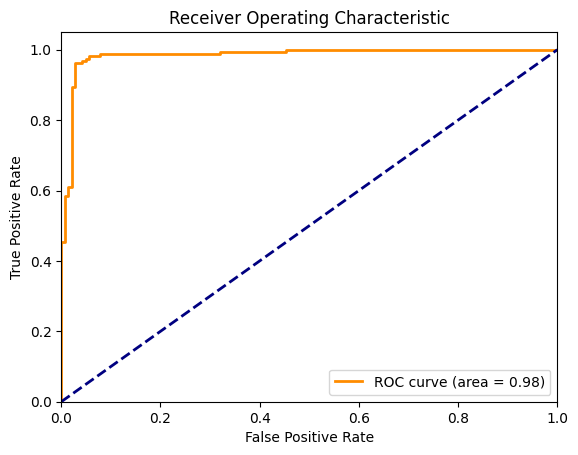

In [ ]:
# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()